In [151]:
# vampW code

from scipy.stats import norm
import numpy as np
import sympy
import scipy

# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior: # checked!
    la = 0.5
    sigma = 1
    
    def __init__(self, la, sigma):
        self.la = la
        self.sigma = sigma
    
def den_beta(r,gam1,prior): # checked!
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(sigma + 1.0/gam1))
    ratio = gam1 * r / (gam1 + 1/sigma) * B / (A + B)
    return ratio

def der_den_beta(r,gam1,prior): # checked!
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(sigma + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (sigma + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/sigma))
    print("alpha1 part I = ", gam1 / (gam1 + 1/sigma) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/sigma) )
    ratio = gam1 / (gam1 + 1/sigma) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/sigma)
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        
        # Denoising x
        print("->DENOISING")
        vect_den_beta = lambda x: den_beta(x, gam1, prior)
        x1_hat = vect_den_beta(r1)
        #print("shape of x1_hat = ", x1_hat.shape )
        #print("shape of beta_true = ", beta_true.shape )
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # reporting quality of estimation
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        print("alpha1 = ", alpha1)
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z
        z1_hat = den_z(p1, tau1, y, alpha, mu) 
        # reporting quality of estimation
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        beta1 = np.sum( der_den_z(p1, tau1, y, alpha, mu) ) / n
        print("beta1 = ", beta1)
        p2 = (z1_hat - beta1 * p1) / (1-beta1)
        tau2 = tau1 * (1-beta1) / beta1
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m;
        print("alpha2 = ", alpha2)
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        beta2 = (1-alpha2) * m / n;
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        tau1 = tau2 * (1-beta2) / beta2
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z
    
    
    
    


In [152]:
from numpy import random
import numpy as np
import sympy

emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def sim_pheno(X, beta, mu, h2):
    # logY_i = mu + xi beta + c(wi - Ewi), wi = - standard Gumbel distribution
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    wi = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp( mu + g + c * (wi + emc) )
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha
    
    

gam1 =  0.01
Var(y) =  0.5859424123766374
tau1 =  0.1
alpha =  3.0254572662977512
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.4544245722877536
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.662542605356976
l2 error for z1_hat =  0.8624741439532181
beta1 =  0.04660328789799974
true tau2 =  7.136138618648774
tau2 = 2.045771350271879
->LMMSE
corr(x2_hat, beta_true) =  [[0.58470216]]
l2 error for x2_hat =  0.8651783887854876
alpha2 =  0.7687985438421514
true gam1 =  2.2887604465361666
gam1 =  0.7586105115797002
corr(z2_hat, beta_true) =  [[0.7164899]]
l2 error for z2_hat =  0.7622088986956643
true tau1 =  7.184372064603175
tau1 =  6.802664919416516


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.09375754]
corr(x1_hat, beta_true) =  0.6141601506627782
l2 error for x1_

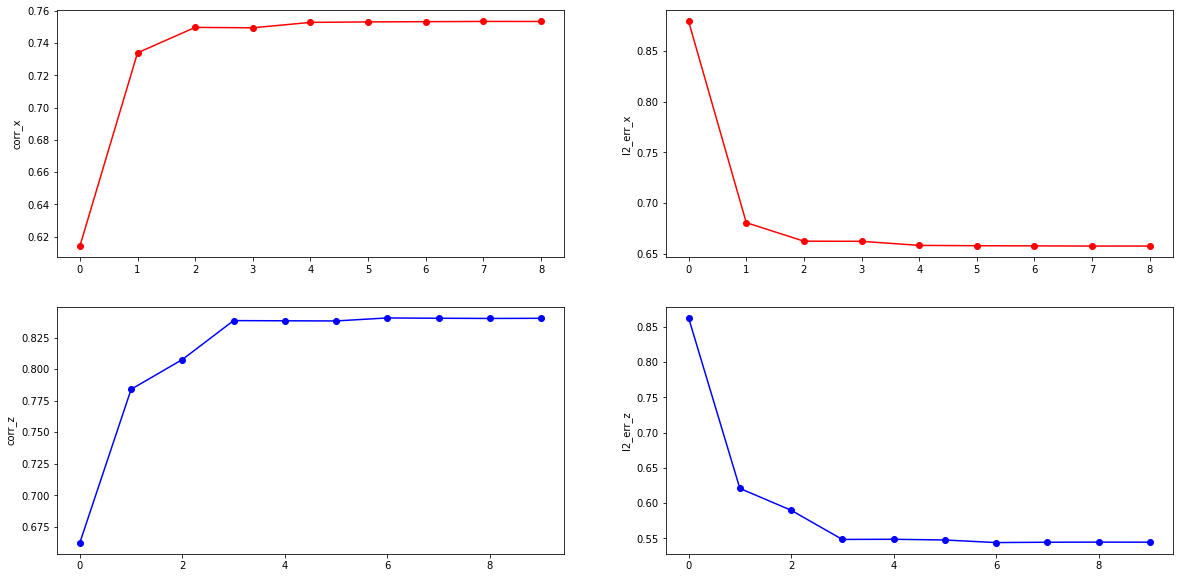

In [155]:
# running simulation
from numpy import random
import matplotlib.pyplot as plt

n=800
m=800
p=0.4
la=0.4
sigma=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)
gam1 = 1.0 / (la * sigma)
gam1 = 1e-2
print("gam1 = ", gam1)
pr = prior(la = la, sigma = sigma)
mu = 0

print("Var(y) = ", np.var(y))
tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.ylabel('corr_x')
plt.plot(range(maxiter-1), corrs_x, 'ro-')
plt.subplot(222)
plt.ylabel('l2_err_x')
plt.plot(range(maxiter-1), l2_errs_x, 'ro-')
plt.subplot(223)
plt.ylabel('corr_z')
plt.plot(range(maxiter), corrs_z, 'bo-')
plt.subplot(224)
plt.ylabel('l2_err_z')
plt.plot(range(maxiter), l2_errs_z, 'bo-')
plt.show()


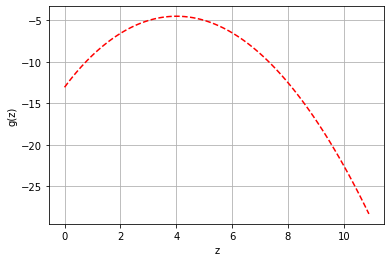

In [101]:
# plotting function g(z)

import numpy as np
import sympy
import matplotlib.pyplot as plt

emc = float( sympy.S.EulerGamma.n(10) )

tau1 = 1
p = 5
mu = 0
alpha = 1
y = 1

def g(z):
    return -alpha * z - np.power(y, alpha) * np.exp(-alpha*(z+mu) - emc) - (z-p)*(z-p)*tau1/2 

net = np.arange(0, 11.0, 0.1)

plt.figure()
plt.plot(net, g(net), 'r--')
plt.grid(True)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.savefig('gz.png')
plt.show()